# Unit Commitment with Multi-Objective PSO (MOPSO)
This notebook solves a unit commitment problem with two generating units over a short planning horizon.  
We optimize **two competing objectives**:

- **Cost** (fuel + startup)
- **Emissions** (operational + startup)

We use **Multi-Objective Particle Swarm Optimization (MOPSO)** and construct a **Pareto frontier** to expose the cost–emissions trade-off.

## Abstract
This notebook presents a classical swarm-optimization solution to the Unit Commitment problem using Multi-Objective Particle Swarm Optimization (MOPSO). The goal is to minimize generation cost while satisfying power-demand balance and operational constraints.

## How to Run
- Python 3.9+
- Run all cells from top to bottom.
- All required libraries must be installed beforehand.

## Problem Context & Objective
The Unit Commitment problem determines which generation units should be ON or OFF across a scheduling horizon in order to minimize total operating cost while meeting electricity demand and respecting technical constraints.

## Notebook Structure
- Method
- Implementation
- Results
- Discussion
- Key Takeaways
- References


# Unit Commitment with Multi-Objective PSO (MOPSO)
This notebook solves a toy unit commitment problem with two generating units over a short planning horizon.  
We optimize **two competing objectives**:

- **Cost** (fuel + startup)
- **Emissions** (operational + startup)

We use **Multi-Objective Particle Swarm Optimization (MOPSO)** and construct a **Pareto frontier** to expose the cost–emissions trade-off.



## Problem definition
For each unit and hour we choose dispatch power \(P_{i,t}\) subject to capacity limits and demand satisfaction.

**Constraints**
- Capacity: \(P_{i,t}=0\) (off) or \(P_{i,t}\in[P_i^{min},P_i^{max}]\)
- Startup indicator \(y_{i,t}\in\{0,1\}\) is 1 when a unit transitions from off→on.
- Demand: \(\sum_i P_{i,t} \ge D_t\) for each hour \(t\)

**Objectives (minimize)**
- Cost: \(\sum_{i,t} c_i P_{i,t} + S_i y_{i,t}\)
- Emissions: \(\sum_{i,t} e_i P_{i,t} + E^{start}_i y_{i,t}\)

## Pareto frontiers
In multi-objective optimization, objectives often conflict, meaning no single solution simultaneously optimizes all objectives. Instead, we seek a set of Pareto-optimal solutions.
A solution is Pareto-optimal if no other feasible solution improves one objective without degrading at least one other objective.
The collection of all Pareto-optimal solutions forms the Pareto Frontier (or Pareto Front).
In this study:
Objective 1: Minimize total generation cost
Objective 2: Minimize total emissions
Each point on the Pareto Frontier represents a trade-off between cost and emissions.
Moving along the frontier improves one objective at the expense of the other.
Rather than producing a single “best” answer, PSO/MOPSO and QPSO construct an archive of non-dominated solutions, which approximates the Pareto Frontier and provides decision-makers with a spectrum of feasible operating strategies.

## PSO and MOPSO
**PSO intuition:** a swarm of candidate solutions (particles) moves through the search space using:
- inertia (keep moving),
- cognition (return toward its personal best),
- social pull (move toward global best / leaders).

**MOPSO:** replaces the single “global best” with a **leader archive** of non-dominated solutions.  
Particles are guided by randomly sampled leaders from the archive to encourage diverse Pareto coverage.

In [ ]:

import random, copy, math
import matplotlib.pyplot as plt

random.seed(0)


In [2]:
# Problem data 
units = {
    "Unit A": {"P_min": 20, "P_max": 100, "c": 20, "S": 100, "e": 0.9, "E_start": 2.0},
    "Unit B": {"P_min": 0,  "P_max": 80,  "c": 40, "S": 10,  "e": 0.1, "E_start": 0.5},
}
demand = [60, 90, 110, 70]  # MW per hour
unit_names = list(units)
T = len(demand)

print("Units:", unit_names, "| Hours:", T)


Units: ['Unit A', 'Unit B'] | Hours: 4


In [3]:
# Objectives (minimize): cost and emissions
def cost(schedule, units=units):
    return sum(u["c"]*h["generation"] + u["S"]*h["startup"]
               for name, hours in schedule.items()
               for h, u in [(hh, units[name]) for hh in hours])

def emissions(schedule, units=units):
    return sum(u["e"]*h["generation"] + u["E_start"]*h["startup"]
               for name, hours in schedule.items()
               for h, u in [(hh, units[name]) for hh in hours])

def evaluate(schedule):
    return cost(schedule), emissions(schedule)


In [4]:
# Constraints: capacity, startup logic, and demand satisfaction (>= demand each hour)
def is_valid(schedule, units=units, demand=demand):
    # capacity + startup logic
    for name, hours in schedule.items():
        Pmin, Pmax = units[name]["P_min"], units[name]["P_max"]
        prev_on = False
        for t, h in enumerate(hours):
            p, y = h["generation"], h["startup"]
            if p != 0 and not (Pmin <= p <= Pmax):
                return False
            if p == 0 and y != 0:
                return False
            on = p > 0
            if y not in (0, 1):
                return False
            if y == 1 and (t != 0 and prev_on):
                return False
            if y == 0 and (t == 0 and on):  # if on at t=0, startup must be 1
                return False
            prev_on = on

    # demand
    for t in range(len(demand)):
        if sum(schedule[n][t]["generation"] for n in units) < demand[t]:
            return False
    return True


In [5]:
# Pareto utilities + archive maintenance
def dominates(a_cost, a_em, b_cost, b_em):
    return (a_cost <= b_cost and a_em <= b_em) and (a_cost < b_cost or a_em < b_em)

def update_archive(archive, pos, c, e):
    # discard invalid / infinities
    if math.isinf(c) or math.isinf(e):
        return archive

    # new solution dominated by any existing one -> ignore
    if any(dominates(s["cost"], s["emissions"], c, e) for s in archive):
        return archive

    # otherwise keep it and remove dominated archive entries
    archive = [s for s in archive if not dominates(c, e, s["cost"], s["emissions"])]
    archive.append({"pos": copy.deepcopy(pos), "cost": c, "emissions": e})
    return archive


In [ ]:
# Particle + repair
def repair(schedule, units=units, demand=demand):
    sch = copy.deepcopy(schedule)

    # meet demand hour-by-hour using a greedy "cheap+clean" dispatch score
    score = {n: units[n]["c"] + 100*units[n]["e"] for n in units}
    order_inc = sorted(units, key=lambda n: score[n])               # add/increase
    order_dec = sorted(units, key=lambda n: score[n], reverse=True) # decrease

    for t in range(len(demand)):
        gen_t = sum(sch[n][t]["generation"] for n in units)

        # add generation if short
        if gen_t < demand[t]:
            need = demand[t] - gen_t
            for n in order_inc:
                if need <= 0:
                    break
                Pmin, Pmax = units[n]["P_min"], units[n]["P_max"]
                p = sch[n][t]["generation"]
                if p == 0:
                    add = min(Pmax, max(Pmin, need))
                else:
                    add = min(need, Pmax - p)
                sch[n][t]["generation"] = p + add
                need -= add

        # reduce generation if surplus (respect Pmin)
        gen_t = sum(sch[n][t]["generation"] for n in units)
        if gen_t > demand[t]:
            excess = gen_t - demand[t]
            for n in order_dec:
                if excess <= 0:
                    break
                Pmin = units[n]["P_min"]
                p = sch[n][t]["generation"]
                if p <= 0:
                    continue
                reducible = p - Pmin if Pmin > 0 else p
                dec = min(excess, max(0, reducible))
                sch[n][t]["generation"] = p - dec
                if sch[n][t]["generation"] <= 0:
                    sch[n][t]["generation"] = 0
                excess -= dec

    # recompute startup flags from generation trajectory
    for n in units:
        prev_on = False
        for t in range(len(demand)):
            on = sch[n][t]["generation"] > 0
            sch[n][t]["startup"] = 1 if (on and (t == 0 or not prev_on)) else 0
            prev_on = on

    return sch

class Particle:
    def __init__(self, units=units, demand=demand):
        self.units, self.T = units, len(demand)
        self.position = repair({
            n: [{"generation": (random.uniform(units[n]["P_min"], units[n]["P_max"]) if random.random() < 0.5 else 0),
                 "startup": 0} for _ in range(self.T)]
            for n in units
        })
        self.velocity = {n: [{"generation": random.uniform(-50, 50)} for _ in range(self.T)] for n in units}

        self.cost, self.emissions = evaluate(self.position)
        self.pbest_pos = copy.deepcopy(self.position)
        self.pbest_cost, self.pbest_em = self.cost, self.emissions

    def step(self, leader_pos, w=0.7, c1=1.4, c2=1.4):
        for n in self.units:
            Pmax = self.units[n]["P_max"]
            for t in range(self.T):
                x = self.position[n][t]["generation"]
                v = self.velocity[n][t]["generation"]
                pbest = self.pbest_pos[n][t]["generation"]
                gbest = leader_pos[n][t]["generation"]

                r1, r2 = random.random(), random.random()
                v = w*v + c1*r1*(pbest - x) + c2*r2*(gbest - x)
                self.velocity[n][t]["generation"] = v

                x_new = max(0, min(Pmax, x + v))
                self.position[n][t]["generation"] = x_new

        self.position = repair(self.position)
        self.cost, self.emissions = evaluate(self.position)

        # update personal best if improved in Pareto sense
        if dominates(self.cost, self.emissions, self.pbest_cost, self.pbest_em):
            self.pbest_pos = copy.deepcopy(self.position)
            self.pbest_cost, self.pbest_em = self.cost, self.emissions


In [7]:
# MOPSO: run swarm + build Pareto archive
def run_mopso(n_particles=30, n_iters=150, seed=0):
    random.seed(seed)
    swarm = [Particle() for _ in range(n_particles)]
    archive = []

    # initialize archive
    for p in swarm:
        archive = update_archive(archive, p.position, p.cost, p.emissions)

    for it in range(n_iters):
        # choose a leader from the Pareto archive (fallback: random particle)
        leader = random.choice(archive)["pos"] if archive else random.choice(swarm).position

        for p in swarm:
            p.step(leader)
            archive = update_archive(archive, p.position, p.cost, p.emissions)

    # sort for plotting
    frontier = sorted(archive, key=lambda s: s["cost"])
    return frontier

frontier = run_mopso()
print("Pareto solutions:", len(frontier))


Pareto solutions: 4488


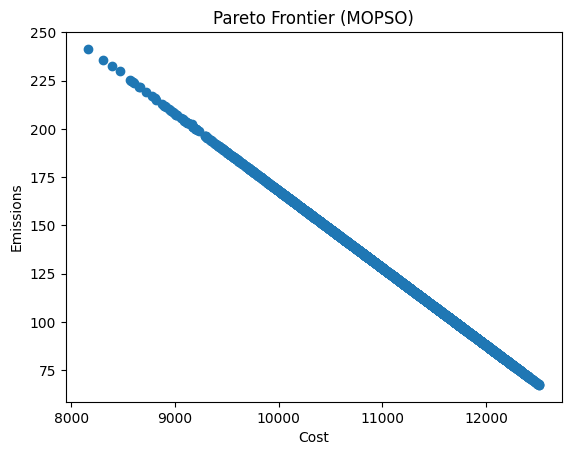

In [8]:
# Plot Pareto frontier
costs = [s["cost"] for s in frontier]
ems = [s["emissions"] for s in frontier]

plt.figure()
plt.scatter(costs, ems)
plt.xlabel("Cost")
plt.ylabel("Emissions")
plt.title("Pareto Frontier (MOPSO)")
plt.show()


## Key Takeaways
* MOPSO provides a robust classical baseline for solving the Unit Commitment optimization problem.
* Swarm-based optimization effectively balances exploration and exploitation for cost minimization.
* This notebook serves as a reference classical benchmark for comparison with quantum-inspired approaches.

## Notes
- The frontier shows the trade-off: lower cost typically requires higher emissions (and vice versa).
- In real systems, additional constraints and stochasticity (renewables, outages) make the landscape more challenging.
